In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import seaborn as sns
%matplotlib inline

In [2]:
device="cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

In [4]:
transform=transforms.Compose([
    transforms.ToTensor()
])

In [5]:
train_dataset=datasets.MNIST(root="./data",train=True,download=True,transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 114305343.99it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24178781.20it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 32129427.49it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3454938.12it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)

In [7]:
class ConvAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.en=nn.Sequential(#解像度を減らす
            nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16,out_channels=16,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
        )
        self.de=nn.Sequential(#解像度を増やす
            nn.Conv2d(in_channels=16,out_channels=16,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=16,out_channels=8,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=8,out_channels=1,kernel_size=3,padding=1),
            nn.Tanh(),#ReLUではなく損失が下がる傾向があるためTanh(ハイパボリックタンジェント)の活性化関数を使用する
        )
    def forward(self,x):
            x=self.en(x)
            x=self.de(x)
            return x

In [8]:
model=ConvAE()
model.to(device)

ConvAE(
  (en): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (de): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)

In [9]:
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [10]:
num_pachs=15
losses=[]
for epoch in range(num_pachs):
    running_loss=0.0
    for imgs,_ in train_loader:
        imgs=imgs.to(device)
        optimizer.zero_grad()
        output=model(imgs)
        loss=criterion(output,imgs)
        running_loss+=loss.item()
        loss.backward()
        optimizer.step()
    running_loss/=len(train_loader)
    losses.append(running_loss)
    print("epoch: {},loss: {}".format(epoch,running_loss))


epoch: 0,loss: 0.01047452628860871
epoch: 1,loss: 0.005154353446637591
epoch: 2,loss: 0.00428209349612395
epoch: 3,loss: 0.003864655671020349
epoch: 4,loss: 0.0036274989256014425
epoch: 5,loss: 0.0034640115696936845
epoch: 6,loss: 0.0033336462719986836
epoch: 7,loss: 0.0032319482925037544
epoch: 8,loss: 0.0031511818217734495
epoch: 9,loss: 0.0030934088341891767
epoch: 10,loss: 0.0030450939587006965
epoch: 11,loss: 0.0030073185959209998
epoch: 12,loss: 0.0029799853733430306
epoch: 13,loss: 0.0029540166101107994
epoch: 14,loss: 0.002932186936214566


In [11]:
plt.style.use("ggplot")

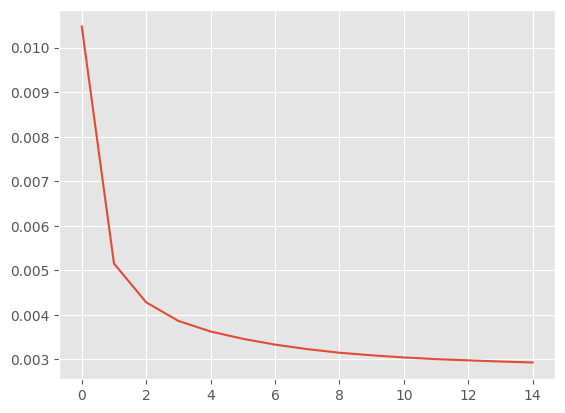

In [12]:
plt.plot(losses)

In [13]:
data_iter=iter(train_loader)

In [14]:
imgs,_=next(data_iter)

In [15]:
img=imgs[0]

In [16]:
img_permute=img.permute(1,2,0)

<Axes: >

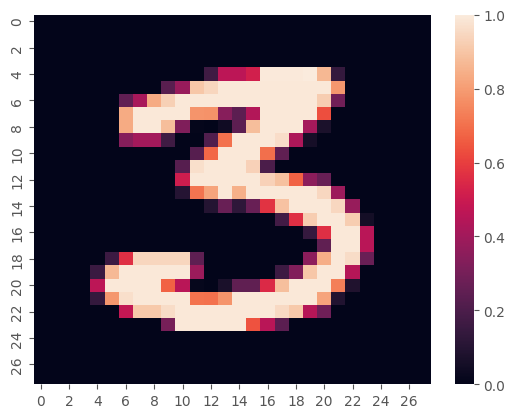

In [18]:
sns.heatmap(img_permute[:,:,0])

In [19]:
x_en=model.en(imgs.to(device))

In [20]:
x_en2=x_en[0].permute(1,2,0)

<Axes: >

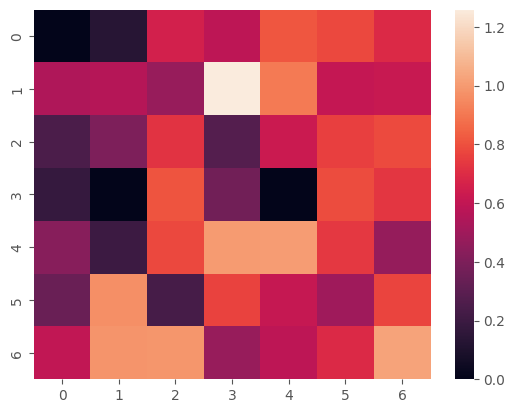

In [21]:
sns.heatmap(x_en2[:,:,0].detach().to("cpu"))

In [22]:
x_ae=model(imgs.to(device))

<Axes: >

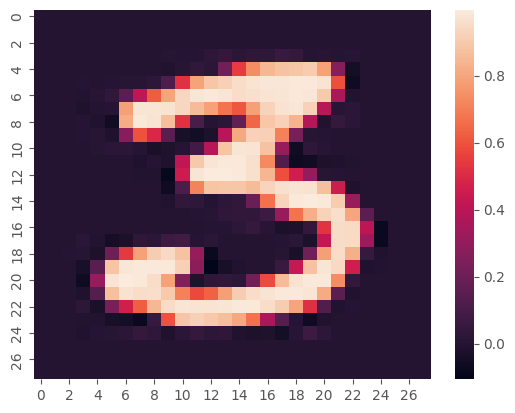

In [26]:
sns.heatmap(x_ae[0].permute(1,2,0).detach().to("cpu")[:,:,0])